### Projection effect - First order corrections
- Referencs: van Leeuwen (2009), Jadhav et al. (2024)

The PM ($\mu_{\alpha*,i},\mu_{\delta*,i}$) and RV ($RV_{i}$) resulting from the projection effect of the cluster motion can be calculated as follows:

\begin{equation}
\begin{split}
RV_{i} &\approx 
RV_{0}+\dfrac{\kappa}{\varpi_0}
\left(\cos\delta_0\,\Delta\alpha_i\,\mu_{\alpha*,0}+\Delta\delta_i\,\mu_{\delta,0}\right)\\
%
\mu_{\alpha*,i} &\approx 
\frac{\varpi_i}{\varpi_0}\left(\mu_{\alpha*,0}-\dfrac{\Delta\alpha_i\,\cos\delta_0\,RV_{0}\,\varpi_0}{\kappa}+
\Delta\alpha_i\,\sin\delta_0\,\mu_{\delta,0}
\right)\\
%
\mu_{\delta,i} &\approx 
\frac{\varpi_i}{\varpi_0}\left(\mu_{\delta,0}-\dfrac{\Delta\delta_i\,RV_{0}\,\varpi_0}{\kappa} - \Delta\alpha_i\,\sin\delta_0\,\mu_{\alpha*,0}\right)\\
\end{split}
.\end{equation}
Here, 
$RV_{0}$ is the cluster RV, 
$\varpi_0$ is its parallax,
$\varpi_i$ is the stellar parallax,
$\delta_0$ is the cluster declination,
($\mu_{\alpha*,0}$, $\mu_{\delta,0}$) is the cluster's PM,
($\Delta\alpha_i$, $\Delta\delta_i$) is the stellar angular separation from the cluster centre in radians, and
$\kappa$ is 4.74047 (the conversion factor for 1 mas/yr at 1 kpc to 1 km/s).

The PM ($\mu_{\alpha*, corr}$, $\mu_{\delta, corr}$) and RV ($RV_{corr}$) corrected for the bulk cluster motion and projection effect are as follows:
\begin{equation}
    \begin{split}
        RV_{corr} & \approx RV - RV_i\\
        \mu_{\alpha*, corr} & \approx \mu_{\alpha*} - \mu_{\alpha*,i}\\
        \mu_{\delta, corr} & \approx \mu_{\delta} - \mu_{\delta,i}\\
    \end{split}
,\end{equation}
where
$RV$ is the stellar RV and
($\mu_{\alpha*}$, $\mu_{\delta}$) is the stellar PM.

Implemented in the `Cluster.get_first_order_corrections` function.

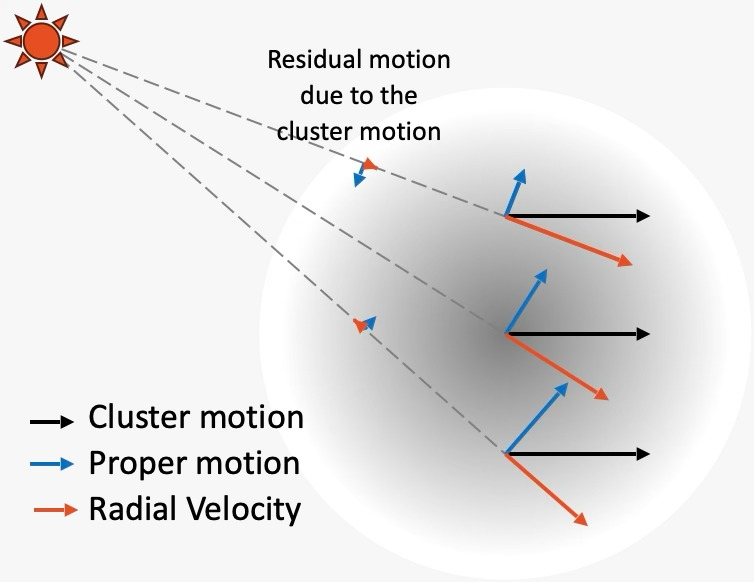

In [35]:
from astropy import units as u
from astropy import constants as const
from astropy.table import QTable, hstack, Table, vstack
from astropy.coordinates import Angle
import matplotlib.pyplot as plt
from numpy import sin, cos
import numpy as np
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import pandas as pd
import astropy.coordinates as coord


@u.quantity_input
def polar_to_tangential_projection(x: u.rad, y: u.rad,
                                   x0: u.rad = None, y0: u.rad = None):
    from astropy.stats import sigma_clipped_stats, sigma_clip

    x, y = x.to(u.rad), y.to(u.rad)
    if x0 is None:
        x0, x_median, x_stddev = sigma_clipped_stats(x)
    if y0 is None:
        y0, y_median, y_stddev = sigma_clipped_stats(y)
    # coordinate txnsformation from sky to tangent plane (orthogonal projection)
    Δx = (cos(y) * sin(x-x0))*u.rad
    Δy = (sin(y) * cos(y0) - cos(y) * sin(y0) * cos(x-x0))*u.rad
    return Δx.to(u.deg), Δy.to(u.deg), x0.to(u.deg), y0.to(u.deg)

@u.quantity_input
def convert_proper_motion_to_kms(proper_motion: u.mas/u.yr, distance: u.pc):
    """
    Convert proper motion to linear motion at a given distance.

    Args:
        proper_motion (Quantity): The proper motion of the object.
        distance (Quantity): The distance to the object.

    Returns:
        Quantity: The linear motion of the object at the given distance.
    """
    pm_kms = convert_angle_to_distance(
        proper_motion.to(u.rad/u.s)*u.s, distance)
    pm_kms = (pm_kms/u.s)
    return pm_kms.to(u.km/u.s)


@u.quantity_input
def convert_angle_to_distance(angle: u.rad, distance: u.pc):
    """
    Convert an angular size to a linear size at a given distance.

    Args:
        angle (Quantity): The angular size of the object.
        distance (Quantity): The distance to the object.

    Returns:
        Quantity: The linear size of the object at the given distance.
    """
    size = np.tan(angle/2.) * 2.*distance
    return size.to(u.pc)

def convert_distance_to_angle(distance=None, size=None):
    """
    Calculates the angular size for a given distance and size.

    Args:
        distance (float or Quantity): The distance to the object in units of length (e.g. meters, kilometers, miles, etc.).
        size (float or Quantity): The size of the object in units of distance.

    Returns:
        float or Quantity: The angular size of the object in astropy Quantity.
    """
    angle = 2. * np.arctan(size / (2. * distance))

    if not isinstance(size, u.Quantity):
        angle = angle * u.rad

    return angle

class Cluster:
    @u.quantity_input
    def __init__(self,
                 ra:u.deg,
                 dec:u.deg,
                 parallax:u.mas,
                 pmra:u.mas/u.yr,
                 pmdec:u.mas/u.yr,
                 radial_velocity:u.km/u.s,
                 ra0:u.deg,
                 dec0:u.deg,
                 parallax0:u.mas,
                 pmra0:u.mas/u.yr,
                 pmdec0:u.mas/u.yr,
                 radial_velocity0:u.km/u.s):
        data = QTable()
        data['ra'] = ra
        data['dec'] = dec
        data['parallax'] = parallax
        data['pmra'] = pmra
        data['pmdec'] = pmdec
        data['radial_velocity'] = radial_velocity
        self.data = data

        self.ra0 = ra0
        self.dec0 = dec0
        self.parallax0 = parallax0
        self.distance0 = self.parallax0.to(u.pc, equivalencies=u.parallax())
        self.pmra0 = pmra0
        self.pmdec0 = pmdec0
        self.radial_velocity0 = radial_velocity0

        self.wrap_ra = False
        if (data['ra'].max() > 270*u.deg) & (data['ra'].min() < 90*u.deg):
            self.wrap_ra = True

        self.get_first_order_corrections()

        Δra, Δdec, _, _ = polar_to_tangential_projection(self.data['ra'], self.data['dec'], self.ra0, self.dec0)
        self.data['delta_ra'] = Δra
        self.data['delta_dec'] = Δdec

        self.data['delta_ra_pc'] = convert_angle_to_distance(angle = self.data['delta_ra'],
                                  distance = self.distance0)
        self.data['delta_dec_pc'] = convert_angle_to_distance(angle = self.data['delta_dec'],
                                  distance = self.distance0)

        self.data['pmra_corr_kms'] = convert_proper_motion_to_kms(proper_motion = self.data['pmra_corr'], distance=self.distance0)
        self.data['pmdec_corr_kms'] = convert_proper_motion_to_kms(proper_motion = self.data['pmdec_corr'], distance=self.distance0)

        c = coord.SkyCoord(ra=self.data['ra'],
                           dec=self.data['dec'],
                           pm_ra_cosdec=self.data['pmra'],
                           pm_dec=self.data['pmdec'],
                           radial_velocity=self.data['radial_velocity'],
                           distance=self.data['parallax'].to(u.pc, equivalencies=u.parallax()))
        self.data['x'] = c.galactocentric.x
        self.data['y'] = c.galactocentric.y
        self.data['z'] = c.galactocentric.z
        self.data['v_x'] = c.galactocentric.v_x
        self.data['v_y'] = c.galactocentric.v_y
        self.data['v_z'] = c.galactocentric.v_z
    
    def get_first_order_corrections(self):
        wrap = 180*u.deg if self.wrap_ra else 360*u.deg
        α_i = Angle(self.data['ra']).wrap_at(wrap).to(u.rad).value
        δ_i = self.data['dec'].to(u.rad).value
        μ_α_i = self.data['pmra'].to(u.mas/u.yr).value
        μ_δ_i = self.data['pmdec'].to(u.mas/u.yr).value
        v_rad_i = self.data['radial_velocity'].to(u.km/u.s).value
        ϖ_i = self.data['parallax'].to(u.mas).value

        α_0 = Angle(self.ra0).wrap_at(wrap).to(u.rad).value
        δ_0 = self.dec0.to(u.rad).value
        μ_α_0 = self.pmra0.to(u.mas/u.yr).value
        μ_δ_0 = self.pmdec0.to(u.mas/u.yr).value
        v_rad_0 = self.radial_velocity0.to(u.km/u.s).value
        ϖ_0 = self.parallax0.to(u.mas).value

        κ = 4.74047  # 1 mas/yr at 1 kpc to 1 km/s
        Δα = α_i - α_0
        Δδ = δ_i - δ_0

        Δv_rad = Δα*κ*μ_α_0*cos(δ_0)/ϖ_0 + Δδ*κ*μ_δ_0/ϖ_0
        Δμ_α = Δα*(μ_δ_0*sin(δ_0) - v_rad_0*ϖ_0*cos(δ_0)/κ)
        Δμ_δ = -Δα*μ_α_0*sin(δ_0) - Δδ*v_rad_0*ϖ_0/κ

        v_rad_corr_i = v_rad_i - (Δv_rad + v_rad_0)
        μ_α_corr_i = μ_α_i - (Δμ_α + μ_α_0)*ϖ_i/ϖ_0
        μ_δ_corr_i = μ_δ_i - (Δμ_δ + μ_δ_0)*ϖ_i/ϖ_0

        self.data['pmra_corr'] = μ_α_corr_i*u.mas/u.yr
        self.data['pmdec_corr'] = μ_δ_corr_i*u.mas/u.yr
        self.data['radial_velocity_corr'] = v_rad_corr_i*u.km/u.s

    def plot_radec(self, ax=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(5,5))
        ax.scatter(self.data['ra'], self.data['dec'],
                   c='0.5', zorder=0, marker='.', rasterized=True)
        ax.set(xlabel='α [deg]', ylabel='δ [deg]')
        ax.invert_xaxis()
        ax.grid()

    def plot_xy_galactocentric(self, ax=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(5,5))
        ax.scatter(self.data['x'], self.data['y'],
                   c='0.5', zorder=0, marker='.', rasterized=True)
        ax.set(xlabel='x [pc]', ylabel='y [pc]')
        ax.set_aspect('equal',adjustable='datalim')
        ax.grid()
     
    def plot_xy_galactocentric_with_arrows(self, ax=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(5,5))
        ax.quiver(self.data['x'], self.data['y'],
                  self.data['v_x'].value - np.nanmedian(self.data['v_x'].value), 
                  self.data['v_y'].value - np.nanmedian(self.data['v_y'].value),
                  rasterized=True)
        ax.set(xlabel='x [pc]', ylabel='y [pc]')
        ax.set_aspect('equal',adjustable='datalim')
        ax.grid()

    def plot_delta_radec(self, ax=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(5,5))
        ax.scatter(self.data['delta_ra'], self.data['delta_dec'],
                   c='0.5', zorder=0, marker='.', rasterized=True)
        ax.set(xlabel='Δα [deg]', ylabel='Δδ [deg]')
        ax.invert_xaxis()
        ax.set_aspect('equal',adjustable='datalim')
        ax.grid()        

    def plot_delta_radec_pc(self, ax=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(5,5))
        ax.scatter(self.data['delta_ra_pc'], self.data['delta_dec_pc'],
                   c='0.5', zorder=0, marker='.', rasterized=True)
        ax.set(xlabel='Δα [pc]', ylabel='Δδ [pc]')
        ax.invert_xaxis()
        ax.set_aspect('equal',adjustable='datalim')
        ax.grid()     

    def plot_vpd(self, ax=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(5,5))
        ax.set_title('VPD')
        ax.scatter(self.data['pmra'],
                   self.data['pmdec'], rasterized=True)
        ax.set(xlabel='$μ_α$ [mas yr$^{-1}$]',
               ylabel='$μ_δ$ [mas yr$^{-1}$]')

    def plot_pm_residual_quiver(self, ax=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(5,5))
        # U has to be -ve to account for flipping xaxis
        ax.quiver(self.data['delta_ra'].value, self.data['delta_dec'].value, -
                  self.data['pmra_corr'].value, self.data['pmdec_corr'].value,
                  color='C0')
        ax.invert_xaxis()
        ax.set(xlabel='Δα [deg]', ylabel='Δδ [deg]',title='Residual PM')
        self.add_scale_bar_distance(ax)
        ax.set_aspect('equal',adjustable='datalim')

    def plot_pm_residual_quiver_pc(self, ax=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(5,5))
        # U has to be -ve to account for flipping xaxis
        ax.quiver(self.data['delta_ra_pc'].value, self.data['delta_dec_pc'].value, -
                  self.data['pmra_corr'].value, self.data['pmdec_corr'].value,
                  color='C0')
        ax.invert_xaxis()
        ax.set(xlabel='Δα [pc]', ylabel='Δδ [pc]',title='Residual PM')
        ax.set_aspect('equal',adjustable='datalim')

    def add_scale_bar_distance(self, ax, size=5*u.pc):
        # Adds a scale bar of 5 pc
        asb = AnchoredSizeBar(ax.transData,
                              convert_distance_to_angle(
                                  self.distance0, size).to(u.deg).value,
                              '%d pc' % (size.to(u.pc).value),
                              loc=3,
                              pad=0.1, borderpad=0.5, sep=5,
                              frameon=False)

- Getting mean cluster properties from Hunt2024

```python
DIR_CAT = '/vol/aibn182/data1/vjadhav/data/'

df_clusters = pd.read_csv(DIR_CAT+'Hunt_2024/clusters_plus.csv').set_index('name')
df_clusters[['ra','dec','parallax','pmra','pmdec','radial_velocity']].loc['NGC_2632']

ra                 130.088104
dec                 19.665873
parallax             5.404143
pmra               -35.943451
pmdec              -12.903007
radial_velocity     33.940812
Name: NGC_2632, dtype: float64
```

<QTable length=1299>
        name          dtype    unit    class   n_bad
-------------------- ------- -------- -------- -----
                  ra float64      deg Quantity     0
                 dec float64      deg Quantity     0
            parallax float64      mas Quantity     0
                pmra float64 mas / yr Quantity     0
               pmdec float64 mas / yr Quantity     0
     radial_velocity float64   km / s Quantity   912
           pmra_corr float64 mas / yr Quantity     0
          pmdec_corr float64 mas / yr Quantity     0
radial_velocity_corr float64   km / s Quantity   912
            delta_ra float64      deg Quantity     0
           delta_dec float64      deg Quantity     0
         delta_ra_pc float64       pc Quantity     0
        delta_dec_pc float64       pc Quantity     0
       pmra_corr_kms float64   km / s Quantity     0
      pmdec_corr_kms float64   km / s Quantity     0
                   x float64       pc Quantity     0
                   y floa

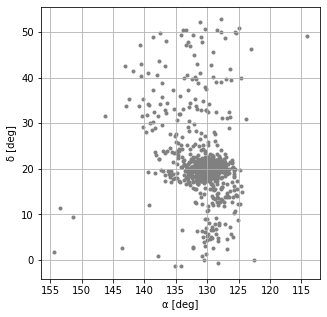

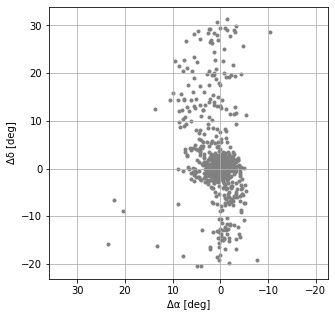

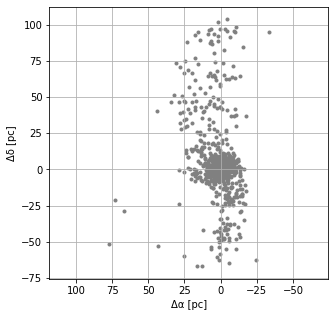

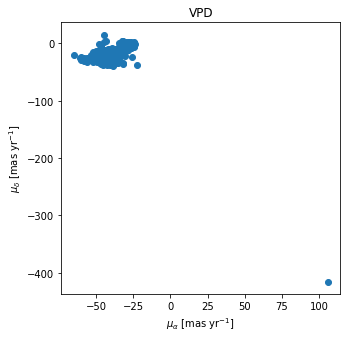

In [ ]:
# Test data of NGC 2632 cluster + tail
df = pd.read_csv('test_cluster_NGC_2632.csv')
df = df[df.distance_cluster<100]

# Loading stellar data and cluster mean values for transformations
cluster = Cluster(ra=df['ra'].values*u.deg,
                  dec=df['dec'].values*u.deg,
                  parallax=df['parallax'].values*u.mas,
                  pmra=df['pmra'].values*u.mas/u.yr,
                  pmdec=df['pmdec'].values*u.mas/u.yr,
                  radial_velocity=df['radial_velocity'].values*u.km/u.s,
                  ra0=130.0881*u.deg,
                  dec0=19.66587*u.deg,
                  parallax0=5.40414*u.mas,
                  pmra0=-35.94345*u.mas/u.yr,
                  pmdec0=-12.90300*u.mas/u.yr,
                  radial_velocity0=33.94081*u.km/u.s,
                  )
cluster.plot_radec()
cluster.plot_delta_radec()
cluster.plot_delta_radec_pc()
cluster.plot_vpd()
cluster.plot_pm_residual_quiver()
cluster.plot_pm_residual_quiver_pc()
cluster.plot_xy_galactocentric()
cluster.plot_xy_galactocentric_with_arrows()

print(cluster.data.info)
print(cluster.data)